In [ ]:
!pip install --quiet prophet

In [ ]:
!pip install --quiet pmdarima

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_palette('pastel')
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from keras.models import Sequential
from keras.layers import LSTM, Dense, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf
import xgboost as xgb
from prophet import Prophet
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
import os
import sys
from scipy import stats
from scipy.stats import gamma, kstest
from scipy.stats import anderson
import statsmodels.api as sm
#sys.stdout = open(os.devnull, 'w') #supress outputs

Este notebook es análogo al de comparandoModelos, solo que omitiremos las explicaciones y nos dedicaremos a aplicarle el código a diferentes series de tiempo. Nos saltamos de Funciones directamente a la obtención del los intervalos de confianza.

###Cargamos datos:

In [ ]:
matNombres = [['asalFormalesMen.csv', 'asalFormalesTrim.csv'],
              ['asalInformalesMen.csv', 'asalInformalesTrim.csv'],
              ['conAccesoSSmen.csv', 'conAccesoSStrim.csv'],
              ['sinAccesoSSmen.csv', 'sinAccesoSStrim.csv'],
              ['trabCuentaPropiaMen.csv', 'trabCuentaPropiaTrim.csv']]

In [ ]:
df = pd.read_csv(matNombres[3][0])
df['Periodo'] = pd.to_datetime(df['Periodo'], format='%Y/%m')
df.set_index('Periodo', inplace=True)
total = [int(s.replace(',', '')) for s in df.Total.values]
df.Total = total
df

,Total
Periodo,
2005-01-01,26248603
2005-02-01,26521502
2005-03-01,26655200
2005-04-01,26161506
2005-05-01,27002774
...,...
2023-05-01,35253081
2023-06-01,35583204
2023-07-01,36330095


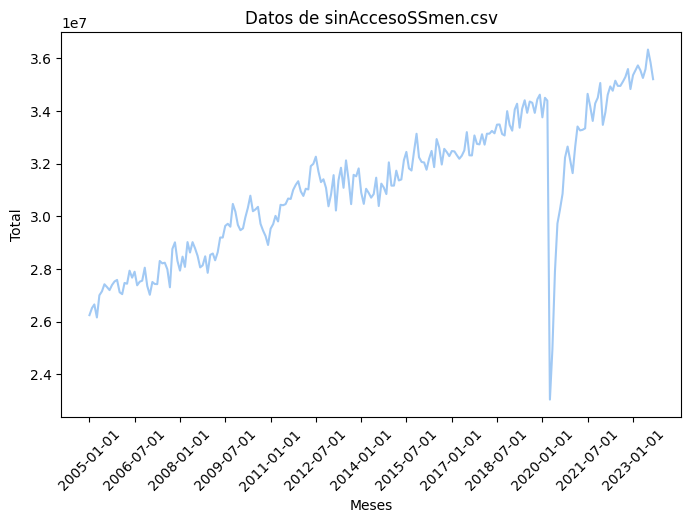

In [ ]:
plt.figure(figsize=(8, 5))
plt.title(f'Datos de {matNombres[3][0]}')
plt.xlabel('Meses')
plt.ylabel('Total')
plt.plot(df['Total'])
plt.xticks(df.index[::18], rotation=45)
plt.show()

Ahora los trimestrales (estos son los datos originales de los cuales se extrapola para obtener los mensuales):

In [ ]:
df2 = pd.read_csv(matNombres[0][1])
df2['Periodo'] = pd.PeriodIndex(df2['Periodo'], freq='Q')
df2.set_index('Periodo', inplace=True)
total = [int(s.replace(',', '')) for s in df2.Total.values]
df2.Total = total
df2.index = df2.index.to_timestamp()
df2

FileNotFoundError: [Errno 2] No such file or directory: 'asalFormalesTrim.csv'

In [ ]:
plt.figure(figsize=(8, 5))
plt.title(f'Datos de {matNombres[0][1]}')
plt.xlabel('Trimestres')
plt.ylabel('Total')
plt.plot(df2['Total'])
plt.xticks(df2.index[::7], rotation=45)
plt.show()

Interpolamos los valores de la serie trimestral para pasarla a una con valores mensuales, parecida a df.

In [ ]:
#Volvemos a cargar los datos
df2 = pd.read_csv(matNombres[0][1])
df2['Periodo'] = pd.PeriodIndex(df2['Periodo'], freq='Q')
df2.set_index('Periodo', inplace=True)
total = [int(s.replace(',', '')) for s in df2.Total.values]
df2.Total = total

#Interpolamos
df = df2.resample('M').interpolate(method='linear')
df.index = df.index.to_timestamp(freq='M')

plt.figure(figsize=(8, 5))
plt.title(f'Datos de {matNombres[0][1]} interpolados a meses')
plt.xlabel('Meses')
plt.ylabel('Total')
plt.plot(df['Total'])
plt.xticks(df.index[::18], rotation=45)
plt.show()

In [ ]:
df.iloc[175:185, :]

In [ ]:
#Para el matNombres[0][0], definimos un punto de corte para no considerar los datos de la pandemia
df = df.iloc[:180, :]

In [ ]:
plt.plot(df.Total.values)

In [ ]:
_, trend = sm.tsa.filters.hpfilter(df.Total.values)

In [ ]:
plt.plot(trend)

###Funciones

In [ ]:
def createSequences(data, sequenceLength, nAhead): #Crea secuencias de entrenamiento input y target para la red LSTM y GRU
  sequences = []
  targets = []
  for i in range(len(data) - sequenceLength - nAhead):
    sequences.append(data[i:i + sequenceLength])
    targets.append(data[i+sequenceLength:i+sequenceLength+nAhead])
  return np.array(sequences), np.array(targets)

In [ ]:
def createLaggedFeatures(data, lag): #para el xgboost
  for i in range(1, lag + 1):
    data[f'lag_{i}'] = data['target'].shift(-i)
  data.dropna(inplace=True)
  return data

In [ ]:
def backtest(data, model, nModels, minTrainSize, nAhead):
  '''
  data: es una serie de tiempo con las fechas como índice
  model: string del nombre del modelo, p.e 'ARIMA'
  nModels: es el número de modelos/periodos de tiempo a evaluar.
  minTrainSize: es el tamaño mínimo del conjunto de entrenamiento que estamos dispuestos a aceptar
  nAhead: numero de puntos/meses a predecir
  '''
  np.random.seed(0)
  #Escalamos los datos:
  scaler = MinMaxScaler()
  data2 = data.reset_index() #para Prophet pues requiere de las fechas
  data2.columns = ['ds', 'y']
  data1 = data.values #para TCMA pues si no se hace muy pequeño
  fechas = data.reset_index().Periodo.values
  data = scaler.fit_transform(data.values.reshape(-1 ,1)).flatten()

  if minTrainSize>len(data) or (len(data)-minTrainSize)<(nAhead+nModels):
    print('No hay suficientes datos para tus requerimientos')
    return 0

  #Particionamos los datos en conjuntos de train y test:
  intsPartition = np.random.randint(minTrainSize, len(data)-nAhead, nModels)
  trainSets = []
  testSets = []
  trainDates = [] #para ver los periodos en los que estamos teniendo predicciones atípicas
  if model == 'TCMA' or model == 'ARIMA':
    for i in intsPartition:
      trainSets.append(data1[:i])
      trainDates.append(fechas[:i])
      testSets.append(data1[i:i+nAhead])
  elif model == 'Prophet':
    for i in intsPartition:
      trainSets.append(data2.iloc[:i])
      testSets.append(data2['y'].values[i:i+nAhead])
  else:
    for i in intsPartition:
      trainSets.append(data[:i])
      trainDates.append(fechas[:i])
      testSets.append(scaler.inverse_transform(data[i:i+nAhead].reshape(-1 ,1)).flatten())

  #Aplicamos el modelo elegido por el usuario y creamos una matriz de len(nModels)xlen(nAhead) con los errores
  errores = []

  if model=='HoltWinters':
    for train, test in zip(trainSets, testSets):
      model = ExponentialSmoothing(train, seasonal='add', seasonal_periods=4, trend='add')
      model_fit = model.fit()
      pred = model_fit.forecast(steps=nAhead)
      pred = scaler.inverse_transform(pred.reshape(-1 ,1)).flatten()
      errores.append(list(np.abs(pred-test)))
    return np.array(errores)#, trainDates Era para detectar las fechas con predicciones atípicas

  elif model=='LSTM':
    for train, test in zip(trainSets, testSets):
      sequenceLength = 24 #usará los últimos 36 meses para predecir 12, esto se puede ajustar
      last = train[-1] #guardamos el ultimo elemento para usarlo para convertir de la primera diferencia a la escala origianl despues
      train = np.diff(train) #obtenemos la primer diferencia
      train = train[:-sequenceLength].reshape(-1, 1)
      xTest = train[-sequenceLength:].reshape(-1, 1) #en vez de predict(nAhead), el modelo LSTM necesita un sequence de entrada para dar la prediction

      xTrain, yTrain = createSequences(train, sequenceLength, nAhead)

      #Creamos el modelo
      model = Sequential()
      model.add(LSTM(16, activation='relu', return_sequences=True, input_shape=(sequenceLength, 1)))
      model.add(LSTM(8, activation='relu', return_sequences=False))
      model.add(Dense(12))
      model.compile(optimizer='adam', loss='mean_squared_error')
      model.fit(xTrain, yTrain, epochs=10, verbose=0)

      #Predicción
      pred = model.predict(xTest.reshape(1, sequenceLength, 1)).flatten()
      pred = np.array([last+np.sum(pred[:i+1]) for i in range(len(pred))]).reshape(-1, 1) #revertimos la primera diferencia
      pred = scaler.inverse_transform(pred).flatten()
      errores.append(list(np.abs(pred-test)))
    return np.array(errores)

  elif model=='TCMA':
    for train, test in zip(trainSets, testSets):
      _, trend = sm.tsa.filters.hpfilter(train)
      tcma = (trend[-1]/trend[0])**(1/len(trend))-1
      pred = np.array([trend[-1]*((tcma+1)**(i+1)) for i in range(nAhead)])
      errores.append(list(np.abs(pred-test)))
    return np.array(errores)

  elif model=='GRU': #preprocesamiento similar a las LSTM
    for train, test in zip(trainSets, testSets):
      sequenceLength = 24
      last = train[-1]
      train = np.diff(train)
      train = train[:-sequenceLength].reshape(-1, 1)
      xTest = train[-sequenceLength:].reshape(-1, 1)

      xTrain, yTrain = createSequences(train, sequenceLength, nAhead)

      model = Sequential()
      model.add(GRU(16, activation='relu', return_sequences=True, input_shape=(sequenceLength, 1)))
      model.add(GRU(8, activation='relu', return_sequences=False))
      model.add(Dense(12))
      model.compile(optimizer='adam', loss='mean_squared_error')
      model.fit(xTrain, yTrain, epochs=10, verbose=0)

      pred = model.predict(xTest.reshape(1, sequenceLength, 1)).flatten()
      pred = np.array([last+np.sum(pred[:i+1]) for i in range(len(pred))]).reshape(-1, 1)
      pred = scaler.inverse_transform(pred).flatten()
      errores.append(list(np.abs(pred-test)))
    return np.array(errores)

  elif model=='Prophet':
    for train, test in zip(trainSets, testSets):
      model = Prophet() #growth='linear')
      model_fit = model.fit(train)
      future = model.make_future_dataframe(periods=nAhead)
      pred = model.predict(future)['yhat'].values[-nAhead:]
      errores.append(list(np.abs(pred-test)))
    return np.array(errores)

  elif model=='XGBoost':
    for train, test in zip(trainSets, testSets):
      last = train[-1]
      train = np.diff(train)
      df = pd.DataFrame({'target': train})
      lags = 24
      data = createLaggedFeatures(df, lags)
      X = data.drop('target', axis=1).values
      y = data['target'].values
      model = xgb.XGBRegressor()
      model.fit(X, y)
      pred = []
      Xtest = np.append(X[-1, 1:], y[-1])
      for i in range(nAhead):
        pred.append(model.predict(Xtest.reshape(1, -1)))
        Xtest = np.append(Xtest[1:], pred[-1])
      pred = np.array([last+np.sum(pred[:i+1]) for i in range(len(pred))]).reshape(-1, 1)
      pred = scaler.inverse_transform(pred).flatten()
      errores.append(list(np.abs(pred-test)))
    return np.array(errores)#, trainDates

  elif model == 'ARIMA':
    for train, test in zip(trainSets, testSets):
      last = train[-1]
      train = np.diff(train)
      model = auto_arima(train)
      pred = model.predict(n_periods=nAhead, return_conf_int=False)
      pred = np.array([last+np.sum(pred[:i+1]) for i in range(len(pred))])
      errores.append(list(np.abs(pred-test)))
    return np.array(errores)#, trainDates

In [ ]:
def graficaErrores(errores, modelo, nModelos=10):
  overallMean = np.mean(errores)
  overallStd = np.std(errores)
  plt.figure(figsize=(8, 5))
  for i in range(nModelos):
    if nModelos==10:
      plt.plot(errores[i], label=f'Modelo {i}')
    else:
      plt.plot(errores[i])
  plt.title(f'Errores en predicciones con {modelo}')
  plt.xlabel('Meses en adelante predichos')
  plt.ylabel('Error')
  plt.legend()
  annotation = f'Media: {overallMean:.3f}\nDesviación estándar: {overallStd:.3f}'
  plt.annotate(annotation, xy=(0, 0), xytext=(-0.05, -0.25), fontsize=10, textcoords='axes fraction', color='gray')
  file_path = f"/content/{modelo}.png"
  plt.savefig(file_path)
  plt.show()

###Comparación

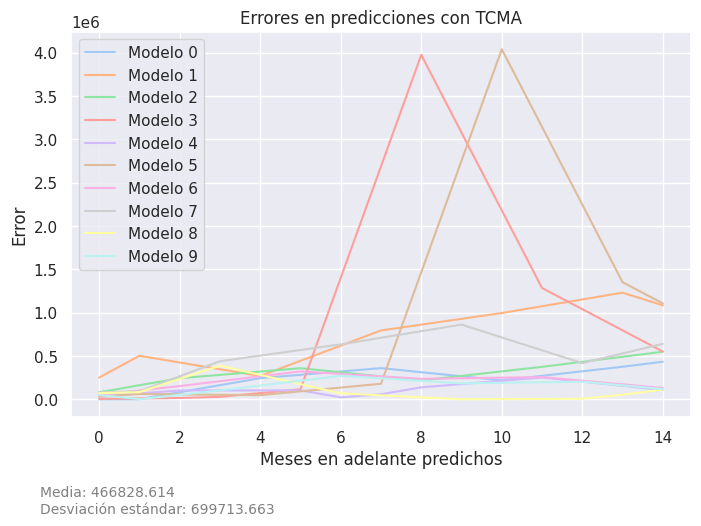

<Figure size 640x480 with 0 Axes>

In [ ]:
nModelos = 10
errores = backtest(df.Total, 'TCMA', nModelos, 120, 12)
graficaErrores(errores, 'TCMA', nModelos)
file_path = "/content/tcma1.png"
plt.savefig(file_path)

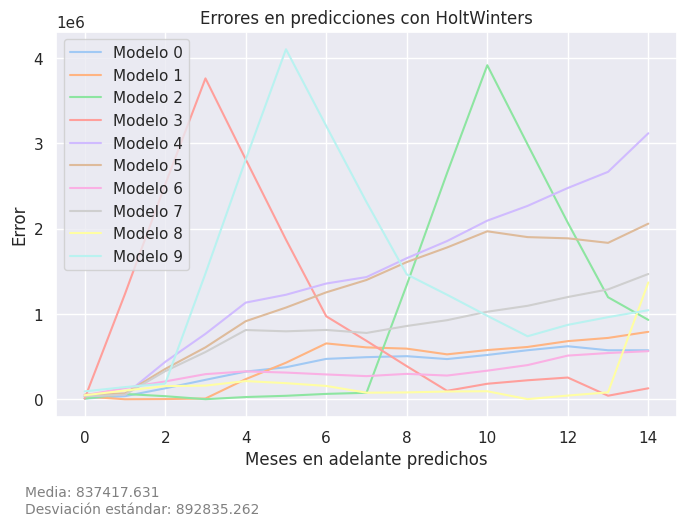

<Figure size 640x480 with 0 Axes>

In [ ]:
nModelos = 10
errores  = backtest(df.Total, 'HoltWinters', nModelos,  120, 12)
graficaErrores(errores, 'HoltWinters', nModelos)
file_path = "/content/holtwinters1.png"
plt.savefig(file_path)

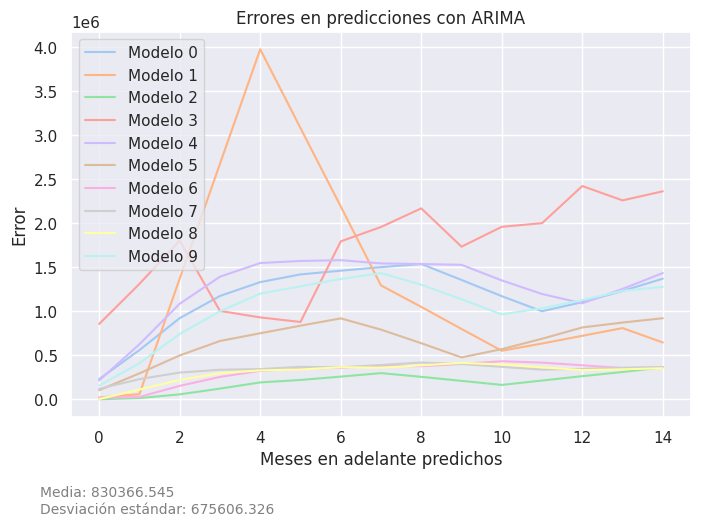

<Figure size 640x480 with 0 Axes>

In [ ]:
nModelos = 10
errores  = backtest(df.Total, 'ARIMA', nModelos,  120, 12)
graficaErrores(errores, 'ARIMA', nModelos)
file_path = "/content/arima1.png"
plt.savefig(file_path)

1/1 [==============================] - 0s 204ms/step


1/1 [==============================] - 0s 202ms/step


1/1 [==============================] - 0s 202ms/step


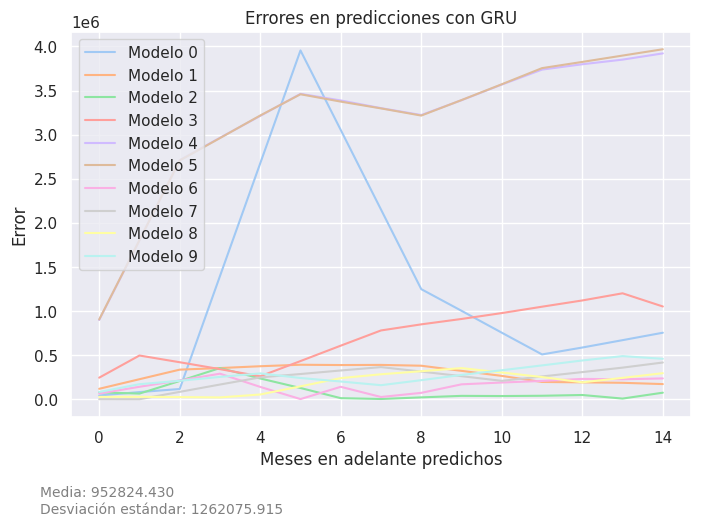

<Figure size 640x480 with 0 Axes>

In [ ]:
errores = backtest(df.Total, 'GRU', 10,  120, 12)
graficaErrores(errores, 'GRU')
file_path = "/content/gru.png"
plt.savefig(file_path)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxe1z4m47/sap_q2n0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxe1z4m47/s70ph2nj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31438', 'data', 'file=/tmp/tmpxe1z4m47/sap_q2n0.json', 'init=/tmp/tmpxe1z4m47/s70ph2nj.json', 'output', 'file=/tmp/tmpxe1z4m47/prophet_modeljoonomi1/prophet_model-20231128200712.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:07:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:07:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonalit

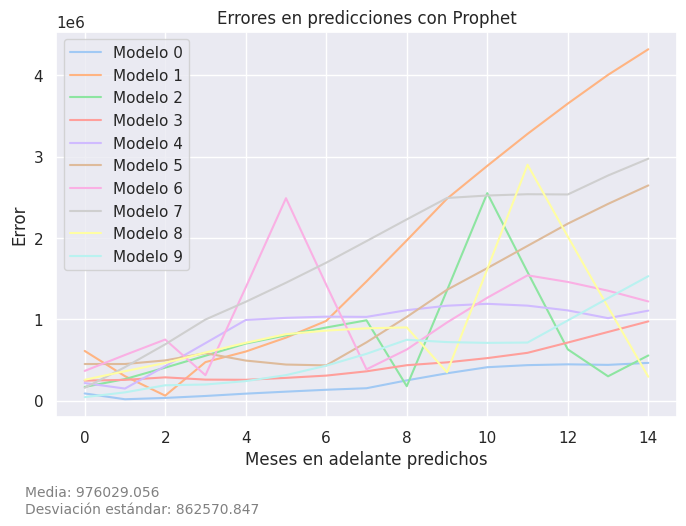

<Figure size 640x480 with 0 Axes>

In [ ]:
errores = backtest(df.Total, 'Prophet', 10,  120, 12)
graficaErrores(errores, 'Prophet')
file_path = "/content/prophet.png"
plt.savefig(file_path)

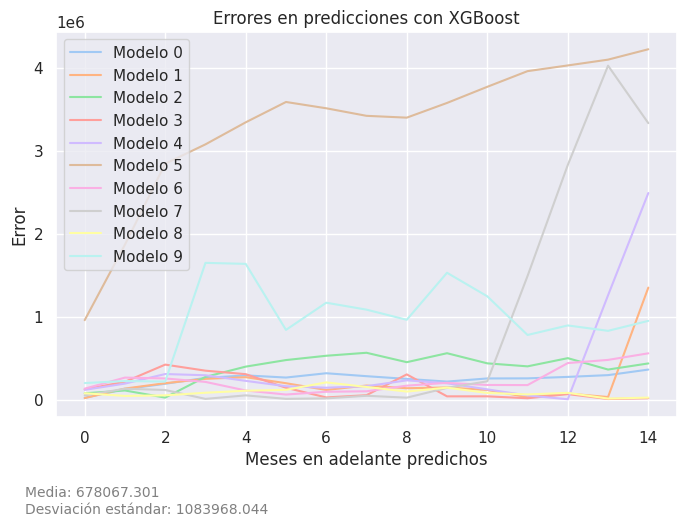

<Figure size 640x480 with 0 Axes>

In [ ]:
nModelos = 10
errores  = backtest(df.Total, 'XGBoost', nModelos,  120, 12)
graficaErrores(errores, 'XGBoost', nModelos)
file_path = "/content/xgboost1.png"
plt.savefig(file_path)

1/1 [==============================] - 0s 195ms/step


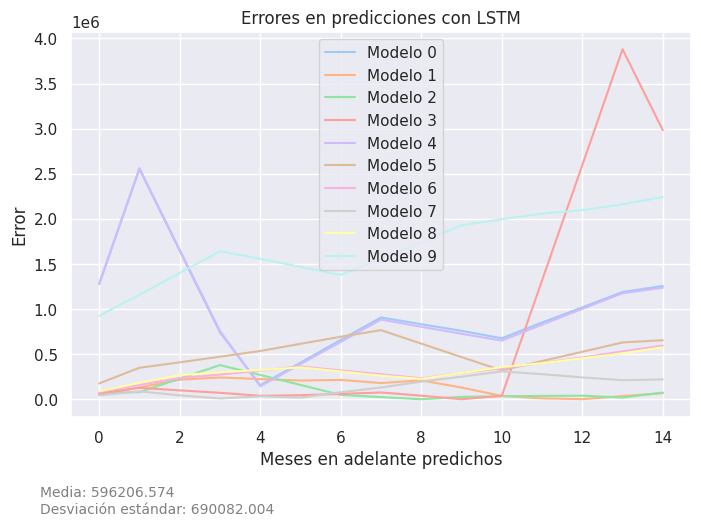

<Figure size 640x480 with 0 Axes>

In [ ]:
nModelos = 10
errores = backtest(df.Total, 'LSTM', nModelos,  120, 12)
graficaErrores(errores, 'LSTM', nModelos)
file_path = "/content/lstm.png"
plt.savefig(file_path)

###Los mejores:

In [ ]:
nModelos = 50
errores  = backtest(df.Total, 'XGBoost', nModelos,  120, 12)
graficaErrores(errores, 'XGBoost', nModelos)
file_path = "/content/xgboost.png"
plt.savefig(file_path)

In [ ]:
nModelos = 50
errores = backtest(df.Total, 'TCMA', nModelos,  120, 12)
graficaErrores(errores, 'TCMA', nModelos)
file_path = "/content/tcma.png"
plt.savefig(file_path)

In [ ]:
nModelos = 50
errores  = backtest(df.Total, 'HoltWinters', nModelos,  120, 12)
graficaErrores(errores, 'HoltWinters', nModelos)
file_path = "/content/holtwinters.png"
plt.savefig(file_path)

In [ ]:
nModelos = 50
errores = backtest(df.Total, 'LSTM', nModelos,  120, 12)
graficaErrores(errores, 'LSTM', nModelos)
file_path = "/content/lstm.png"
plt.savefig(file_path)

In [ ]:
nModelos = 50
errores  = backtest(df.Total, 'ARIMA', nModelos,  120, 12)
graficaErrores(errores, 'ARIMA', nModelos)
file_path = "/content/arima.png"
plt.savefig(file_path)

###Métrica estable:

####Para un modelo:

Ahora hagamos un diagrama de barras para ver la distribución de los errores (juntando los errores del dia 1 al 12 para muchas simulaciones):

In [ ]:
nModelos = 30
daysAhead = 1
errores = backtest(df.Total, 'ARIMA', nModelos,  120, 12).flatten()

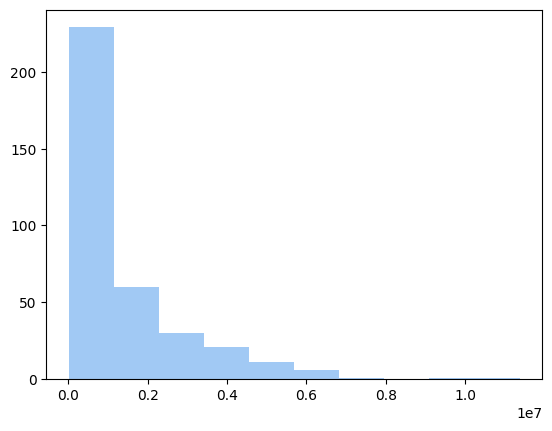

In [ ]:
plt.hist(errores);

Text(0.5, 0, 'Error')

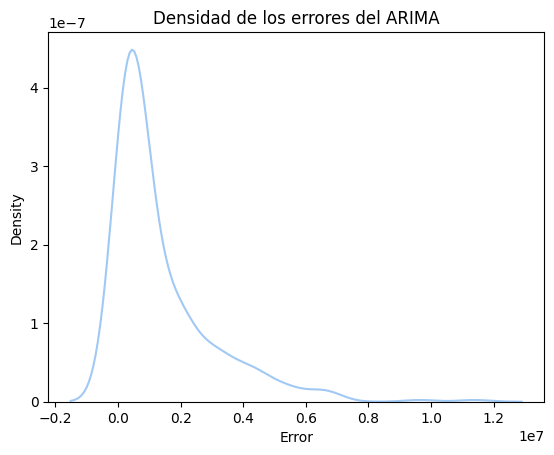

In [ ]:
sns.kdeplot(errores, bw_adjust=1.0, common_norm=False)
plt.title('Densidad de los errores del ARIMA')
plt.xlabel('Error')

Para poder generar intervalos de confianza del promedio del error, usemos el teorema central del límite.

In [ ]:
def toNorm(errs, nSamples, nMeans): #usa el TCL para obtener nMeans muestras de tamaño nSamples y promediiarlas (estandarizando obtenemos ajustes menos precisos por error de redondeo).
  means = []
  for i in range(nMeans):
    means.append(np.mean(np.random.choice(errs, size=nSamples, replace=True)))
    #means.append((np.mean(np.random.choice(errs, size=nSamples, replace=True))-np.mean(errs))/(np.std(errs)))
  return means

Text(0.5, 0, 'Error')

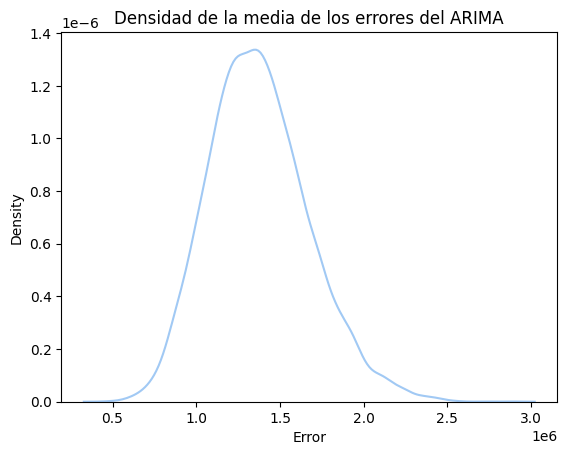

In [ ]:
X = toNorm(errores, 30, 10000)
sns.kdeplot(X, bw_adjust=1.0, common_norm=False) #obtenemos algo similar para TCMA
plt.title('Densidad de la media de los errores del ARIMA')
plt.xlabel("Error")

(array([4.400e+01, 6.060e+02, 2.203e+03, 3.204e+03, 2.394e+03, 1.072e+03,
        3.650e+02, 9.300e+01, 1.700e+01, 2.000e+00]),
 array([ 470853.36868764,  711698.46013763,  952543.55158762,
        1193388.64303761, 1434233.7344876 , 1675078.82593759,
        1915923.91738758, 2156769.00883758, 2397614.10028757,
        2638459.19173756, 2879304.28318755]),
 <BarContainer object of 10 artists>)

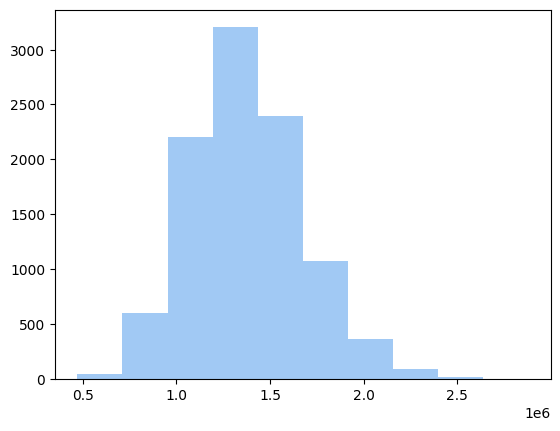

In [ ]:
plt.hist(X)

Vemos si la distribución es normal:

In [ ]:
_, shapiro = stats.shapiro(X)
print(shapiro) #Es menor a 0.05 entonces no es normal

1.7348542745958983e-26


/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Vemos que la distribución se parece a una gamma. Corroboremos si es el caso con la prueba Kolmogorov-Smirnov.

In [ ]:
a, loc, b=stats.gamma.fit(X)
kstest(X, 'gamma', args=(a, loc, b))

KstestResult(statistic=0.004659924485645117, pvalue=0.9809805263606355, statistic_location=1477440.313686674, statistic_sign=1)

Vemos que el pvalor es mayor a 0.05 por lo que se rechaza la hipótesis nula y decimos que no hay evidencia suficiente para negar que los datos siguen una distribución gamma. Ahora que tenemos los parámetros de la distribución gamma y corroboramos que nuestros datos siguen esa distribución, grafiquemos el ajuste que creamos con la distribución gamma así como nuestros datos:

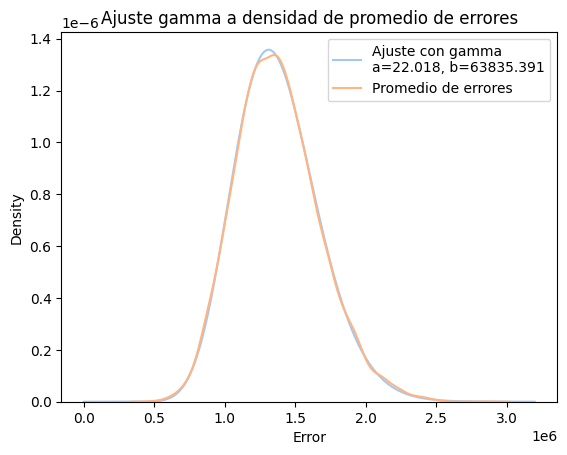

In [ ]:
x = np.linspace(0, 3200000, 1000000)
pdf = gamma.pdf(x, a, loc, b)
plt.plot(x, pdf, label=f'Ajuste con gamma \na={a:.3f}, b={b:.3f}')
plt.title('Ajuste gamma a densidad de promedio de errores')
plt.xlabel('Error')
sns.kdeplot(X, bw_adjust=1.0, common_norm=False, label='Promedio de errores')
plt.legend()

Una vez mostrado un ejemplo, calculemos los intervalos de confianza asumiendo la distribución gamma para las medias de los errores.

In [ ]:
n = 30
confLevel = 0.95

#SEM: standard error of the mean
sem = np.std(X)/np.sqrt(n)

#Critical value de la t-distribution
#n-1 degrees of freedom para una muestra de tamaño n
t_critical = stats.t.ppf((1 + confLevel) / 2, df=n - 1, )

margin_of_error = t_critical * sem

#Confidence interval para la media
mean = a * b + loc  #Media
confInt = (mean - margin_of_error, mean + margin_of_error)
confInt

(1263206.8430131553, 1486993.2411570214)

####Para todos los modelos:

Ahora obtengamos invervalos para los modelos HoltWinters, ARIMA, TCMA y XGBoost. Primero hagamos predicciones de 12 días en 90 periodos diferentes y recabemos los errores:

In [ ]:
def intervalos(df, nModelos, daysAhead, modelo):
  #Obtenemos muestras
  errores = backtest(df.Total, modelo, nModelos, 110, daysAhead).flatten()
  X = toNorm(errores, 30, 10000) #tomamos 10000 muestras de tamaño 30 para promediar cada una

  #Corroboramos que sigan una distribución gamma
  a, loc, b=stats.gamma.fit(X)
  test = kstest(X, "gamma", args=(a, loc, b))

  #Intervalos de confianza:
  n = 30
  confLevel = 0.95
  t_critical = stats.t.ppf((1 + confLevel) / 2, df=n - 1, )
  sem = np.std(X)/np.sqrt(n)
  margin_of_error = t_critical * sem
  mean = a * b + loc
  confInt = (mean - margin_of_error, mean + margin_of_error)
  return test, confInt

Ahora si obtengamos los intervalos de confianza:

In [ ]:
modelos = ['TCMA', 'ARIMA', 'HoltWinters', 'LSTM', 'GRU', 'XGBoost']
tests = []
confInts = []
for i in modelos:
  p, q = intervalos(df, 80, 12, i)
  tests.append(p)
  confInts.append(q)

In [ ]:
print('\tTest gamma e intervalos de confianza para el promedio de los errores de cada modelo')
print('\t(p valor mayor a 0.05 indica que se distribuye como una gamma)')
for i, j, k in zip(modelos, tests, confInts):
  print(f'\n\n{i}: \np-valor={j[1]}\n{k}')